# Initial EDA

Mostly this notebook is me looking at what the data looks like. I'm not really looking for trends in any of the data. I am trying to get a sense of how things are structured and what I am going to need to do get it ready for the modeling. 

This is also the result of a few attempts at EDA. I'v used some of the things I learned in other (probably overwritten or deleted) notebooks and rolled them into here. 

In [50]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from utils.utilities import select_by_date
from utils.utilities import mk_heatmap, value_heatmap, update_grade

In [60]:
# start_date = '2017-01-01'
# end_date = '2017-12-31'

df = pd.read_csv("./data/inspections.csv")
df.inspection_date = pd.to_datetime(df.inspection_date)
# df = select_by_date(df, start_date, end_date)
print("Training Data: N = {}".format(len(df)))
df.head().T

Training Data: N = 236073


,0,1,2,3,4
camis,41471993,50016849,40670353,40585345,40585345
dba,NEW MEI MEI CHINESE RESTAURANT,WIBAR,DUKE'S,SUSHIYA JAPANESE RESTAURANT,SUSHIYA JAPANESE RESTAURANT
boro,Brooklyn,Queens,Manhattan,Manhattan,Manhattan
zipcode,11229,11369,10016,10019,10019
cuisine_description,Chinese,American,American,Japanese,Japanese
inspection_date,2016-01-04 00:00:00,2016-01-05 00:00:00,2016-01-05 00:00:00,2016-01-05 00:00:00,2016-01-05 00:00:00
action,Violations were cited in the following area(s).,Violations were cited in the following area(s).,Violations were cited in the following area(s).,Violations were cited in the following area(s).,Violations were cited in the following area(s).
violation_code,04L,10F,06C,04C,10B
violation_description,Evidence of mice or live mice present in facil...,Non-food contact surface improperly constructe...,Food not protected from potential source of co...,Food worker does not use proper utensil to eli...,Plumbing not properly installed or maintained;...
critical_flag,Y,N,Y,Y,N


In [61]:
df.columns

Index(['camis', 'dba', 'boro', 'zipcode', 'cuisine_description',
       'inspection_date', 'action', 'violation_code', 'violation_description',
       'critical_flag', 'score', 'grade', 'inspection_type', 'latitude',
       'longitude'],
      dtype='object')

### But there are multiple citations for each restaurant in the df

For some reason I missed the fact that each row in the inspections data contains a single violation. We are gonna need to merge all the different rows into single restaurant inspections.

In [62]:
df_single_visits = df.drop_duplicates(subset=['camis', 'inspection_date'])

cols_to_merge = ['violation_code', 'violation_description', 'critical_flag', 'inspection_type']

for col in cols_to_merge:
    df_tmp = df[col].groupby([df.camis, df.inspection_date]).apply(list).reset_index()
    df_single_visits = pd.merge(df_single_visits, df_tmp,  how='left', left_on=['camis','inspection_date'], right_on = ['camis','inspection_date'])
    df_single_visits.drop(columns=f'{col}_x', axis=1, inplace=True)
    df_single_visits.rename(columns={f'{col}_y': f"{col}"}, inplace=True)

In [9]:
df_single_visits.head(5)

,camis,dba,boro,zipcode,cuisine_description,inspection_date,action,score,grade,latitude,longitude,violation_code,violation_description,critical_flag,inspection_type
0,41471993,NEW MEI MEI CHINESE RESTAURANT,Brooklyn,11229.0,Chinese,2016-01-04,Violations were cited in the following area(s).,6.0,A,40.597078,-73.941255,[04L],[Evidence of mice or live mice present in faci...,[Y],[Cycle Inspection / Re-inspection]
1,50016849,WIBAR,Queens,11369.0,American,2016-01-05,Violations were cited in the following area(s).,9.0,A,40.774414,-73.877293,"[10F, 04H]",[Non-food contact surface improperly construct...,"[N, Y]","[Cycle Inspection / Initial Inspection, Cycle ..."
2,40670353,DUKE'S,Manhattan,10016.0,American,2016-01-05,Violations were cited in the following area(s).,7.0,A,40.747683,-73.976704,"[06C, 10F]",[Food not protected from potential source of c...,"[Y, N]","[Cycle Inspection / Initial Inspection, Cycle ..."
3,40585345,SUSHIYA JAPANESE RESTAURANT,Manhattan,10019.0,Japanese,2016-01-05,Violations were cited in the following area(s).,17.0,NaN,40.762738,-73.975558,"[04C, 10B, 02B]",[Food worker does not use proper utensil to el...,"[Y, N, Y]","[Cycle Inspection / Initial Inspection, Cycle ..."
4,41685208,PAPA'S HALAL CHICKEN & GRILL,Staten Island,10303.0,Indian,2016-01-06,Violations were cited in the following area(s).,13.0,A,40.625071,-74.148394,"[09C, 10F, 10B, 06D]",[Food contact surface not properly maintained....,"[N, N, N, Y]","[Cycle Inspection / Re-inspection, Cycle Inspe..."


In [10]:
df_single_visits.shape

(82569, 15)

In [11]:
df_single_visits[df_single_visits.camis==40393243].iloc[0]['violation_description']

['Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.',
 'Cold food item held above 41º F (smoked fish and reduced oxygen packaged foods above 38 ºF) except during necessary preparation.',
 "Evidence of mice or live mice present in facility's food and/or non-food areas.",
 'Sanitized equipment or utensil, including in-use food dispensing utensil, improperly used or stored.']

In [12]:
df_single_visits.iloc[29415]

camis                                                             50054661
dba                                               CINCO DE MAYO RESTAURANT
boro                                                              Brooklyn
zipcode                                                              11218
cuisine_description                                                Mexican
inspection_date                                        2017-08-30 00:00:00
action                     Violations were cited in the following area(s).
score                                                                    9
grade                                                                    A
latitude                                                           40.6401
longitude                                                         -73.9669
violation_code                                             [06D, 10I, 10B]
violation_description    [Food contact surface not properly washed, rin...
critical_flag            

 Which restaurants are visited the most

<IPython.core.display.Javascript object>


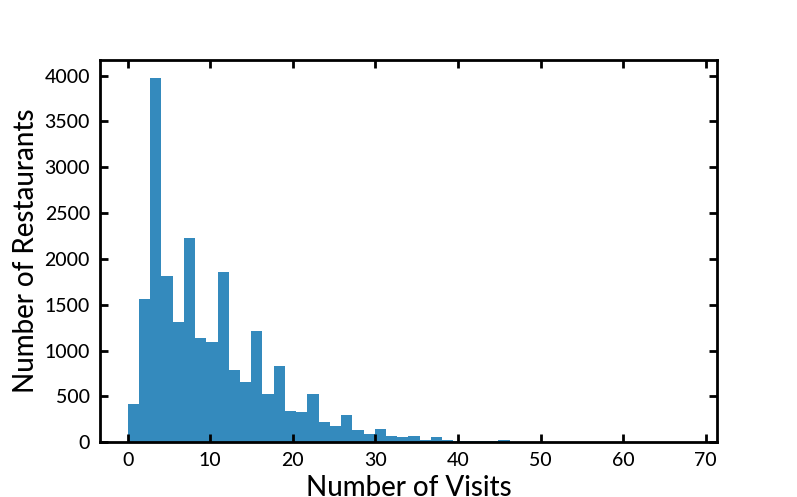

       camis                                 dba  Count
0   41297769                BROTHERS FISH MARKET     68
1   41409441                      GOLDEN STEAMER     64
2   50001789  RESTAURANTE & PANADERIA GUATELINDA     63
3   50036890        NEW SHANGHAI TIDE RESTAURANT     59
4   50035784                 BIG WONG RESTAURANT     58
5   50001693                          ANKA GRILL     58
6   41510846                      218 RESTAURANT     54
7   41187577             HANSOL NUTRITION CENTER     54
8   41669112       LA VIE EN SZECHUAN RESTAURANT     54
9   41664038                       SIMPLY BAKERY     52
10  50069376                             QINGDAO     52
11  41683816             MAX BAKERY & RESTAURANT     52
12  41046492                       CAFE EXCHANGE     51
13  41451560                    GUAN DONG YI JIA     51
14  50002478              VILLA TAPIA RESTAURANT     51
15  50056438         KABAYAN FILIPINO RESTAURANT     51
16  40827287                        AJISEN RAMEN

In [155]:
df_v = df.groupby(['camis', 'dba'],as_index=False)['score'].count()
df_v.rename(columns={'score': 'Count'}, inplace=True)
df_v.sort_values(by='Count', ascending=False, inplace=True)
df_v.reset_index(drop=True,inplace=True)
# df_v.head(20).plot.bar(x='dba', y='Count')
plt.hist(df_v.Count, bins=50)
plt.ylabel('Number of Restaurants')
plt.xlabel('Number of Visits')
print(df_v.head(20))

In [151]:
df_single_visits[df_single_visits.camis==41297769]

,camis,dba,boro,zipcode,cuisine_description,inspection_date,action,score,grade,latitude,longitude,violation_code,violation_description,critical_flag,inspection_type,TMAX,critical
296,41297769,BROTHERS FISH MARKET,Manhattan,10032.0,Seafood,2016-03-11,Violations were cited in the following area(s).,8.0,NaN,40.836121,-73.943382,"[10F, 06D]",[Non-food contact surface improperly construct...,"[N, Y]","[Cycle Inspection / Initial Inspection, Cycle ...",68,1
1638,41297769,BROTHERS FISH MARKET,Manhattan,10032.0,Seafood,2016-05-24,Violations were cited in the following area(s).,31.0,C,40.836121,-73.943382,"[06F, 08A, 04L, 02G, 10F, 04N]",[Wiping cloths soiled or not stored in sanitiz...,"[Y, N, Y, Y, N, Y]","[Cycle Inspection / Re-inspection, Cycle Inspe...",73,1
4501,41297769,BROTHERS FISH MARKET,Manhattan,10032.0,Seafood,2016-09-02,Violations were cited in the following area(s).,NaN,NaN,40.836121,-73.943382,"[20F, nan]","[Current letter grade card not posted., nan]","[N, nan]",[Administrative Miscellaneous / Initial Inspec...,81,0
8396,41297769,BROTHERS FISH MARKET,Manhattan,10032.0,Seafood,2016-11-28,Violations were cited in the following area(s).,21.0,NaN,40.836121,-73.943382,"[08A, 08C, 10B, 04L, 06C]",[Facility not vermin proof. Harborage or condi...,"[N, N, N, Y, Y]","[Cycle Inspection / Initial Inspection, Cycle ...",52,1
11274,41297769,BROTHERS FISH MARKET,Manhattan,10032.0,Seafood,2017-01-20,Violations were cited in the following area(s).,13.0,A,40.836121,-73.943382,"[04M, 09B, 06D]",[Live roaches present in facility's food and/o...,"[Y, N, Y]","[Cycle Inspection / Re-inspection, Cycle Inspe...",45,1
27952,41297769,BROTHERS FISH MARKET,Manhattan,10032.0,Seafood,2017-08-14,Establishment Closed by DOHMH. Violations wer...,79.0,NaN,40.836121,-73.943382,"[04H, 05F, 04K, 04N, 08A, 04M, 02G]","[Raw, cooked or prepared food is adulterated, ...","[Y, Y, Y, Y, N, Y, Y]","[Cycle Inspection / Initial Inspection, Cycle ...",80,1
28553,41297769,BROTHERS FISH MARKET,Manhattan,10032.0,Seafood,2017-08-18,Establishment re-opened by DOHMH,2.0,P,40.836121,-73.943382,[10B],[Plumbing not properly installed or maintained...,[N],[Cycle Inspection / Reopening Inspection],82,0
33402,41297769,BROTHERS FISH MARKET,Manhattan,10032.0,Seafood,2017-10-19,Violations were cited in the following area(s).,6.0,A,40.836121,-73.943382,"[04L, 04M]",[Evidence of mice or live mice present in faci...,"[Y, Y]","[Cycle Inspection / Re-inspection, Cycle Inspe...",71,1
51782,41297769,BROTHERS FISH MARKET,Manhattan,10032.0,Seafood,2018-04-06,Establishment Closed by DOHMH. Violations wer...,51.0,NaN,40.836121,-73.943382,"[10B, 10F, 04M, 08A, 02B, 04L]",[Plumbing not properly installed or maintained...,"[N, N, Y, N, Y, Y]","[Cycle Inspection / Initial Inspection, Cycle ...",62,1
52110,41297769,BROTHERS FISH MARKET,Manhattan,10032.0,Seafood,2018-04-10,Establishment re-opened by DOHMH,14.0,P,40.836121,-73.943382,"[08A, 10F, 09C, 04M]",[Facility not vermin proof. Harborage or condi...,"[N, N, N, Y]","[Cycle Inspection / Reopening Inspection, Cycl...",51,1


# Look at the temporal features of the data

In [27]:
pd.to_datetime(df_single_visits["inspection_date"]).describe()

count                   82569
unique                    957
top       2018-03-28 00:00:00
freq                      249
first     2016-01-04 00:00:00
last      2018-12-31 00:00:00
Name: inspection_date, dtype: object

## Year

<IPython.core.display.Javascript object>


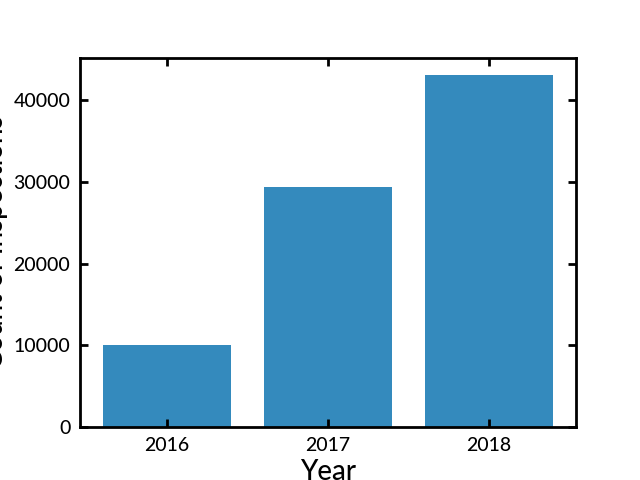

Text(0, 0.5, 'Count of Inspections')

In [28]:
year_hist = df_single_visits.inspection_date.dt.year
year_hist = year_hist.value_counts().sort_index()
year_hist.index = ["2016", "2017", "2018"]
plt.bar(year_hist.index, year_hist.values)
plt.xlabel("Year")
plt.ylabel("Count of Inspections")

## Month

<IPython.core.display.Javascript object>


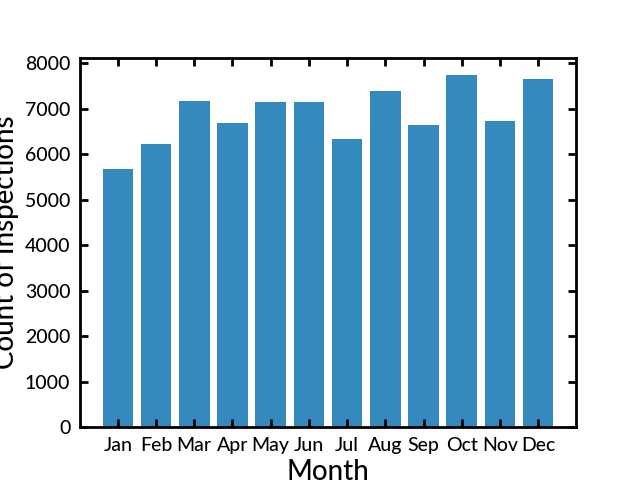

Text(0, 0.5, 'Count of Inspections')

In [29]:
month_hist = pd.to_datetime(df_single_visits["inspection_date"]).dt.month
month_hist = month_hist.value_counts().sort_index()
month_hist.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.bar(month_hist.index, month_hist.values)
plt.xlabel("Month")
plt.ylabel("Count of Inspections")

## Day

<IPython.core.display.Javascript object>


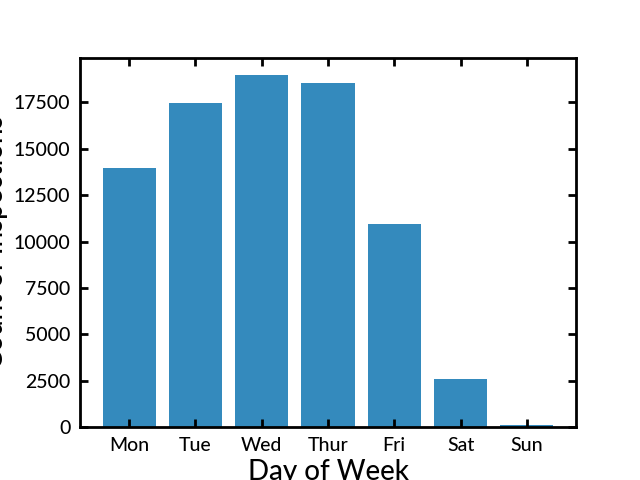

Text(0, 0.5, 'Count of Inspections')

In [30]:
day_hist = pd.to_datetime(df_single_visits["inspection_date"]).dt.weekday
day_hist = day_hist.value_counts().sort_index()
day_hist.index = ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"]
plt.bar(day_hist.index, day_hist.values)
plt.xlabel("Day of Week")
plt.ylabel("Count of Inspections")

# What types of restaurants are being inspected?

<IPython.core.display.Javascript object>


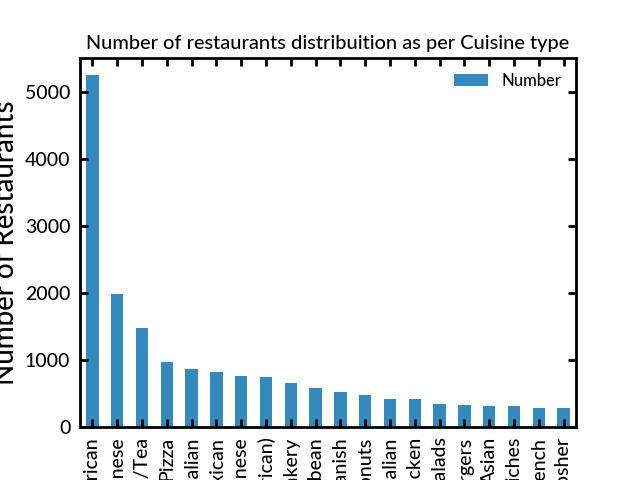

Text(0, 0.5, 'Number of Restaurants')

In [31]:
cus = []
cus_n = []
for i in df_single_visits["cuisine_description"].unique():
    cus.append(i)
    cus_n.append(df[df["cuisine_description"]==i]["camis"].nunique())
my_data_cus = { 'Cuisine Description':cus,'Number':cus_n}
my_data_cus = pd.DataFrame(my_data_cus)
my_data_cus.sort_values(by='Number', ascending=False, inplace=True)
my_data_cus.head(20).plot(x="Cuisine Description", y=["Number"], kind="bar")
plt.title('Number of restaurants distribuition as per Cuisine type')
plt.ylabel('Number of Restaurants')


# How many have critical violations?

In [71]:
nested = df_single_visits['critical_flag'].values.tolist()

df_single_visits['critical'] = [1 if 'Y' in sublist else 0 for sublist in nested]

<IPython.core.display.Javascript object>


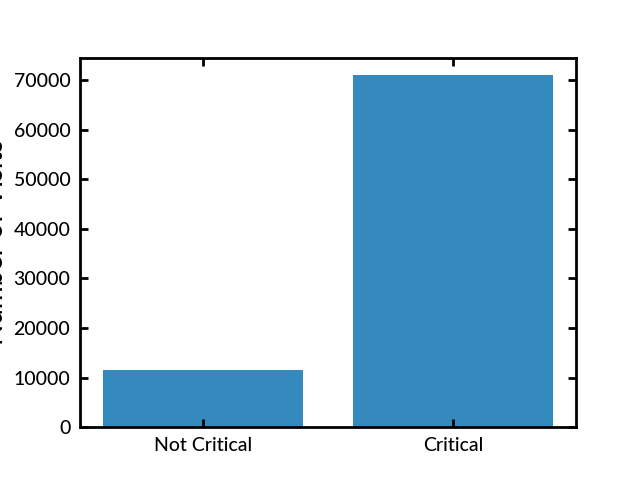

[11588 70981]


In [34]:
month_hist = df_single_visits["critical"]
month_hist = month_hist.value_counts().sort_index()
month_hist.index = ["Not Critical", "Critical"]
plt.bar(month_hist.index, month_hist.values)
plt.ylabel('Number of Visits')
print(month_hist.values)

In [35]:
70981/df_single_visits.shape[0]

0.8596567719119766

So 86% of restaurants visits had a critical violation

<IPython.core.display.Javascript object>


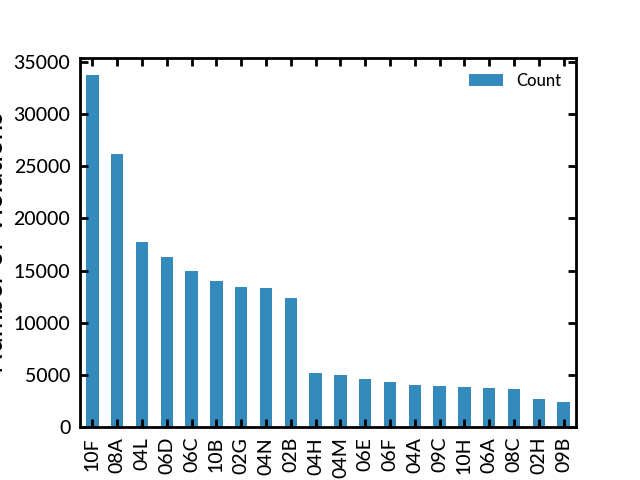

Text(0, 0.5, 'Number of Violations')

In [36]:
#Now let us check the distribution of Violation Types
df_v = df.groupby(['violation_code'],as_index=False)['camis'].count()
df_v.rename(columns={'camis': 'Count'}, inplace=True)
df_v.sort_values(by='Count', ascending=False, inplace=True)
df_v.reset_index(drop=True,inplace=True)
df_v.head(20).plot.bar(x='violation_code', y='Count')
plt.ylabel('Number of Violations')

In [37]:
codes = df.violation_code.unique()

In [40]:
np.sort([c for c in codes if isinstance(c, str)])

array(['02A', '02B', '02C', '02D', '02E', '02F', '02G', '02H', '02I',
       '02J', '03A', '03B', '03C', '03D', '03E', '03F', '03G', '04A',
       '04B', '04C', '04D', '04E', '04F', '04G', '04H', '04I', '04J',
       '04K', '04L', '04M', '04N', '04O', '05A', '05B', '05C', '05D',
       '05E', '05F', '05H', '06A', '06B', '06C', '06D', '06E', '06F',
       '06G', '06H', '06I', '07A', '08A', '08B', '08C', '09A', '09B',
       '09C', '10A', '10B', '10C', '10D', '10E', '10F', '10G', '10H',
       '10I', '10J', '15A1', '15E2', '15E3', '15F1', '15F2', '15F6',
       '15F7', '15F8', '15I', '15J', '15K', '15L', '15S', '15T', '16A',
       '16B', '16C', '16D', '16E', '16F', '17A1', '17A3', '18B', '18C',
       '18D', '18F', '18G', '19A3', '20A', '20D', '20E', '20F', '22A',
       '22B', '22C', '22E', '22F'], dtype='<U4')

Total Number of times Restaurants closed by the Health Inspectors are 9617


<IPython.core.display.Javascript object>


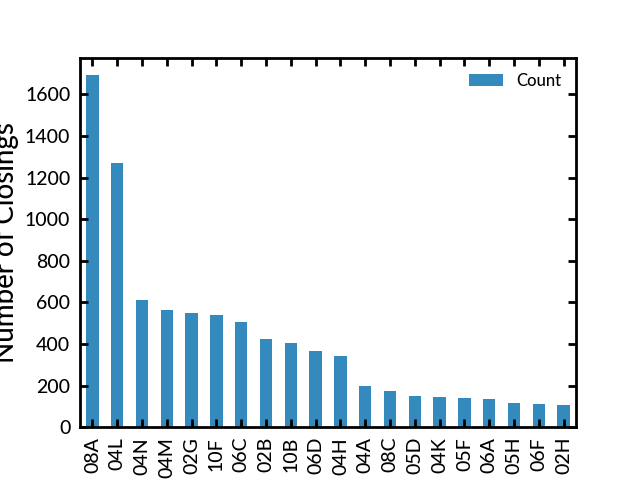

Text(0, 0.5, 'Number of Closings')

In [41]:
my_data_closed = df[df['action'].str.contains("Establishment Closed|Establishment re-closed")]
print ('Total Number of times Restaurants closed by the Health Inspectors are',my_data_closed['action'].count())

my_data_cr = my_data_closed.groupby(['violation_code'],as_index=False)['camis'].count()
my_data_cr.rename(columns={'camis': 'Count'}, inplace=True)
my_data_cr.sort_values(by='Count', ascending=False, inplace=True)
my_data_cr.reset_index(drop=True,inplace=True)
my_data_cr.head(20).plot.bar(x='violation_code', y='Count')
plt.ylabel('Number of Closings')

# Look at the spatial data!

In [43]:
df_single_visits['latitude'].replace(0, np.nan, inplace=True)
df_single_visits['longitude'].replace(0, np.nan, inplace=True)

<IPython.core.display.Javascript object>


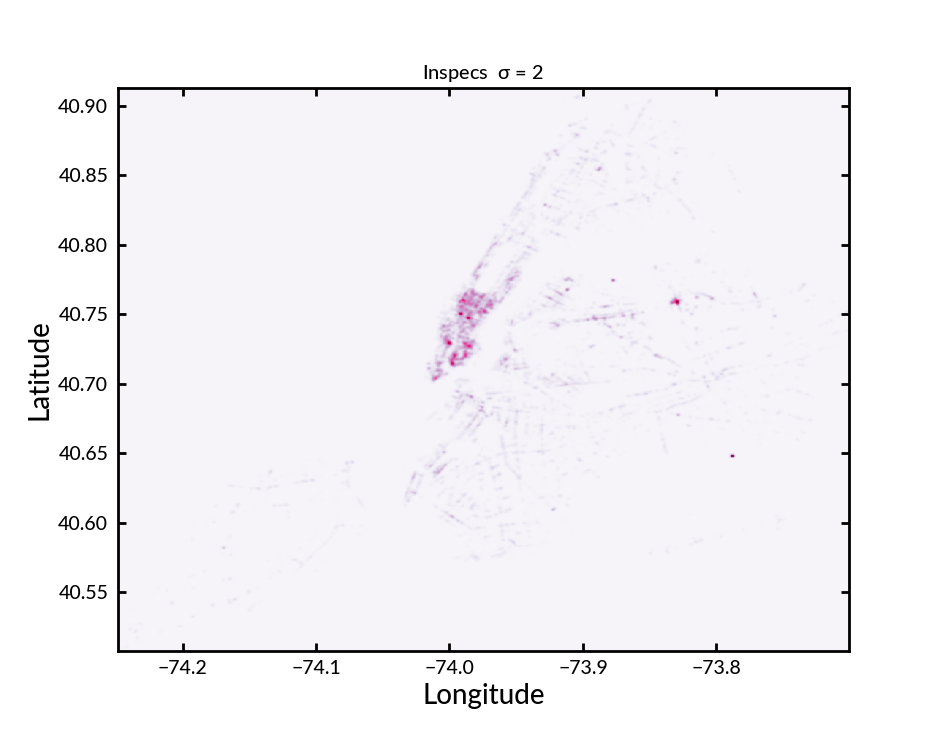

Text(0, 0.5, 'Latitude')

In [44]:
fig, ax = plt.subplots(1,1)

x = df_single_visits.longitude
y = df_single_visits.latitude

s = 2

img, extent, xedges, yedges = mk_heatmap(x, y, s, bins=1000)
ax.imshow(img, extent=extent, origin='lower', cmap=cm.PuRd)
ax.set_title("Inspecs  $\sigma$ = %d" % s)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Other data

In [49]:
threeoneone = pd.read_csv('./data/311.csv')
nypd = pd.read_csv('./data/nypd.csv')

# Replace the missing lats and lons with nan
threeoneone['latitude'].replace(0, np.nan, inplace=True)
threeoneone['longitude'].replace(0, np.nan, inplace=True)
nypd['latitude'].replace(0, np.nan, inplace=True)
nypd['longitude'].replace(0, np.nan, inplace=True)

# Do date things
threeoneone.created_date = pd.to_datetime(threeoneone.created_date)
nypd.complaint_date = pd.to_datetime(nypd.complaint_date)


# make a column to store which day of the week it is... 
# Remember that Monday is 0 Sunday = 6
threeoneone['weekday'] = threeoneone.created_date.dt.weekday
nypd['weekday'] = nypd.complaint_date.dt.weekday

# 311

<IPython.core.display.Javascript object>


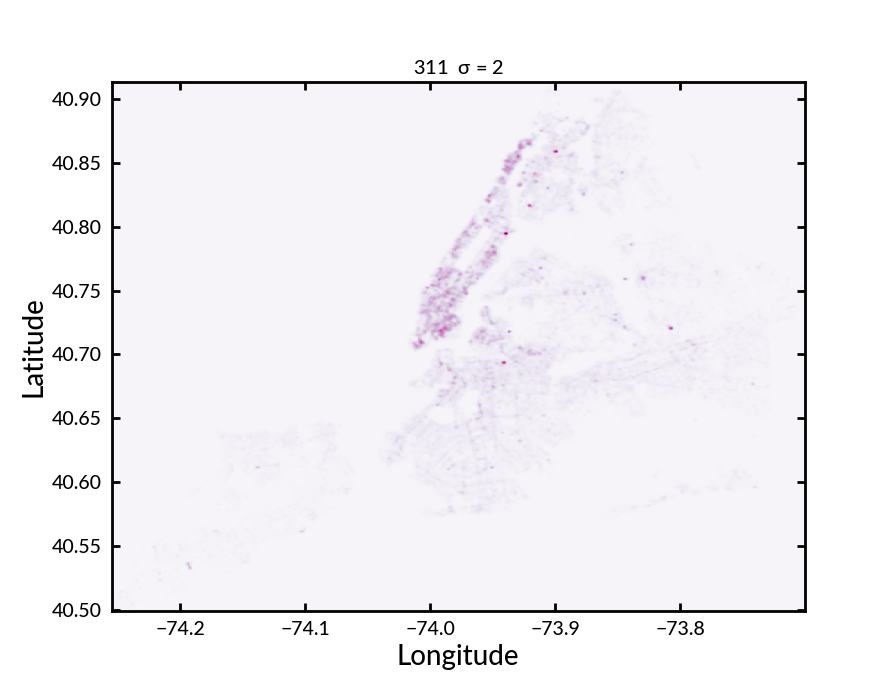

Text(0, 0.5, 'Latitude')

In [50]:
fig, ax = plt.subplots(1,1)

x = threeoneone.longitude
y = threeoneone.latitude

s = 2

img, extent, xedges, yedges = mk_heatmap(x, y, s, bins=1000)
ax.imshow(img, extent=extent, origin='lower', cmap=cm.PuRd)
ax.set_title("311  $\sigma$ = %d" % s)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [51]:
threeoneone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 13 columns):
created_date      300000 non-null datetime64[ns]
agency            300000 non-null object
complaint_type    300000 non-null object
descriptor        299259 non-null object
incident_zip      271668 non-null float64
address_type      293070 non-null object
city              271867 non-null object
facility_type     45185 non-null object
borough           300000 non-null object
latitude          267308 non-null float64
longitude         267308 non-null float64
location_type     178067 non-null object
weekday           300000 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(1), object(8)
memory usage: 29.8+ MB


In [53]:
threeoneone[threeoneone.agency == 'DSNY'].complaint_type.unique()

array(['Request Large Bulky Item Collection',
       'Missed Collection (All Materials)', 'Snow', 'Dirty Conditions',
       'Derelict Vehicles', 'Graffiti', 'Sanitation Condition',
       'Derelict Bicycle', 'Electronics Waste', 'Vacant Lot',
       'Other Enforcement', 'Litter Basket / Request', 'Sweeping/Missed',
       'Recycling Enforcement', 'Sweeping/Inadequate',
       'Electronics Waste Appointment', 'Request Xmas Tree Collection',
       'Overflowing Litter Baskets', 'Sweeping/Missed-Inadequate',
       'Collection Truck Noise', 'Adopt-A-Basket',
       'Overflowing Recycling Baskets'], dtype=object)

In [54]:
threeoneone[threeoneone.agency == 'DEP'].complaint_type.unique()

array(['Sewer', 'Hazardous Materials', 'Air Quality', 'Water System',
       'Industrial Waste', 'Water Conservation', 'Noise', 'FATF', 'Lead',
       'Asbestos', 'Plant', 'FCST', 'ATF', 'Water Quality', 'SRDE'],
      dtype=object)

In [55]:
threeoneone[threeoneone.agency == 'DOHMH'].complaint_type.unique()

array(['Mobile Food Vendor', 'Food Establishment', 'Unleashed Dog',
       'Smoking', 'Illegal Animal Sold', 'Mosquitoes', 'Tattooing',
       'Poison Ivy', 'Illegal Animal Kept as Pet', 'Trans Fat',
       'Pet Shop', 'Day Care', 'Unlicensed Dog',
       'Animal Facility - No Permit', 'Unsanitary Animal Facility',
       'Window Guard', 'Calorie Labeling', 'Indoor Air Quality',
       'Unsanitary Animal Pvt Property', 'Rodent', 'Standing Water',
       'Indoor Sewage', 'Drinking Water', 'Tanning', 'Bottled Water',
       'Beach/Pool/Sauna Complaint', 'X-Ray Machine/Equipment',
       'Harboring Bees/Wasps', 'Lifeguard', 'Non-Residential Heat',
       'Food Poisoning', 'Unsanitary Pigeon Condition', 'Asbestos',
       'Forms', 'Mold', 'Radioactive Material', 'Cooling Tower',
       'Asbestos/Garbage Nuisance'], dtype=object)

In [69]:
from utils.strings import DSNY_311, DEP_311, DOHMH_311

In [72]:
DOHMH_311

['Mobile Food Vendor',
 'Food Establishment',
 'Smoking',
 'Trans Fat',
 'Unlicensed Dog',
 'Animal Facility - No Permit',
 'Calorie Labeling',
 'Indoor Air Quality',
 'Rodent',
 'Standing Water',
 'Indoor Sewage',
 'Drinking Water',
 'Bottled Water',
 'Non-Residential Heat',
 'Food Poisoning',
 'Unsanitary Pigeon Condition',
 'Mold',
 'Radioactive Material',
 'Cooling Tower',
 'Asbestos/Garbage Nuisance']

In [70]:
dsny_mask = threeoneone.complaint_type.isin(DOHMH_311)

<IPython.core.display.Javascript object>


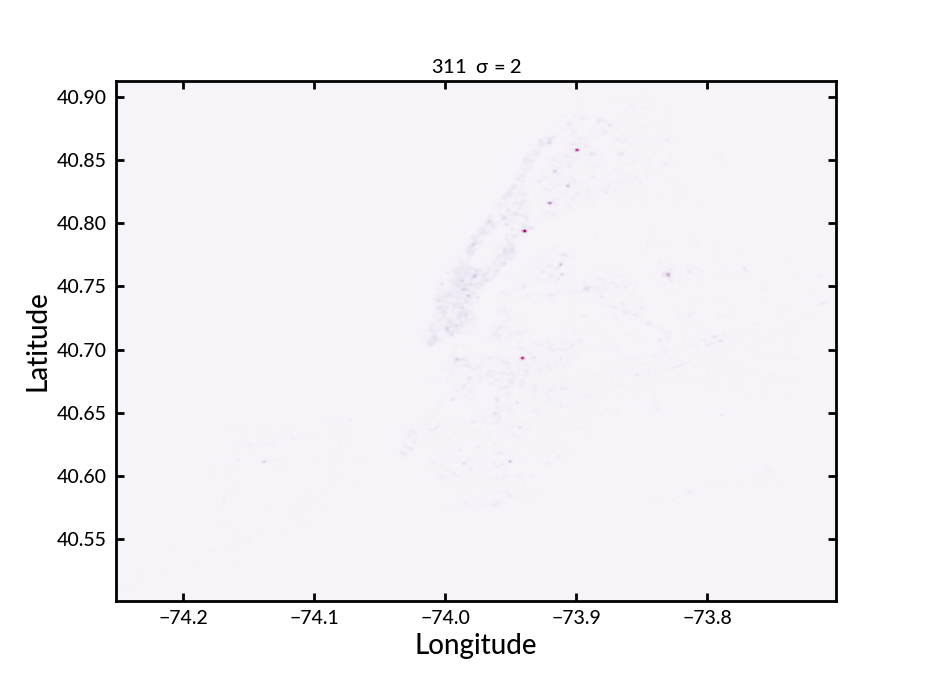

Text(0, 0.5, 'Latitude')

In [73]:
fig, ax = plt.subplots(1,1)

x = threeoneone.longitude[dsny_mask]
y = threeoneone.latitude[dsny_mask]

s = 2

img, extent, xedges, yedges = mk_heatmap(x, y, s, bins=1000)
ax.imshow(img, extent=extent, origin='lower', cmap=cm.PuRd)
ax.set_title("311  $\sigma$ = %d" % s)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# NYPD

In [201]:
nypd = pd.read_csv('./data/full/nypd.csv')
nypd.complaint_date = pd.to_datetime(nypd.complaint_date)

In [202]:
nypd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 8 columns):
complaint_date           300000 non-null datetime64[ns]
complaint_code           300000 non-null int64
complaint_description    299967 non-null object
offense_lvl              300000 non-null object
boro                     299785 non-null object
premisis_type            298870 non-null object
latitude                 299783 non-null float64
longitude                299783 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 18.3+ MB


In [203]:
nypd.complaint_date.describe()

count                  300000
unique                    229
top       2016-01-01 00:00:00
freq                     2318
first     2016-01-01 00:00:00
last      2016-08-16 00:00:00
Name: complaint_date, dtype: object

In [193]:
# match the descriptions to the complaint codes

keys = list(nypd.groupby(['complaint_code', 'complaint_description']).groups.keys())

In [194]:
keys

[(109, 'GRAND LARCENY'),
 (104, 'RAPE'),
 (233, 'SEX CRIMES'),
 (578, 'HARRASSMENT 2'),
 (344, 'ASSAULT 3 & RELATED OFFENSES'),
 (110, 'GRAND LARCENY OF MOTOR VEHICLE'),
 (106, 'FELONY ASSAULT'),
 (351, 'CRIMINAL MISCHIEF & RELATED OF'),
 (361, 'OFF. AGNST PUB ORD SENSBLTY &'),
 (348, 'VEHICLE AND TRAFFIC LAWS'),
 (117, 'DANGEROUS DRUGS'),
 (112, 'THEFT-FRAUD'),
 (341, 'PETIT LARCENY'),
 (126, 'MISCELLANEOUS PENAL LAW'),
 (118, 'DANGEROUS WEAPONS'),
 (235, 'DANGEROUS DRUGS'),
 (347, 'INTOXICATED & IMPAIRED DRIVING'),
 (105, 'ROBBERY'),
 (352, 'CRIMINAL TRESPASS'),
 (107, 'BURGLARY'),
 (121, 'CRIMINAL MISCHIEF & RELATED OF'),
 (236, 'DANGEROUS WEAPONS'),
 (359, 'OFFENSES AGAINST PUBLIC ADMINI'),
 (113, 'FORGERY'),
 (340, 'FRAUDS'),
 (116, 'SEX CRIMES'),
 (114, 'ARSON'),
 (364, 'AGRICULTURE & MRKTS LAW-UNCLASSIFIED'),
 (125, 'NYS LAWS-UNCLASSIFIED FELONY'),
 (675, 'ADMINISTRATIVE CODE'),
 (353, 'UNAUTHORIZED USE OF A VEHICLE'),
 (342, 'PETIT LARCENY OF MOTOR VEHICLE'),
 (358, 'OFFENSES I

In [195]:
# gonna put this in utils/strings.py 
complaint_codes = dict(keys)
# invert to use the descriptions to get the codes
complaint_desc = dict([[v,k] for k,v in complaint_codes.items()])

The only things we are really interested (at least initially) in are:
robbery, burglary and maybe criminal tresspassing.... start with burglary... 

In [196]:
nypd_burglary = nypd[nypd.complaint_code == complaint_desc['BURGLARY']]

In [199]:
nypd_burglary.complaint_date.describe()

count                    7992
unique                    229
top       2016-02-26 00:00:00
freq                       55
first     2016-01-01 00:00:00
last      2016-08-16 00:00:00
Name: complaint_date, dtype: object

# Seems that we are missing a bunch of data from the NYPD

The full data set has more data, but I don't know why we are missing data. Might have to use the full set.

In [30]:
bus = pd.read_csv('./data/full/Legally_Operating_Businesses.csv')

/home/boada/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3050: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
bus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201167 entries, 0 to 201166
Data columns (total 27 columns):
DCA License Number               201167 non-null object
License Type                     201167 non-null object
License Expiration Date          201134 non-null object
License Status                   201167 non-null object
License Creation Date            201167 non-null object
Industry                         201167 non-null object
Business Name                    201117 non-null object
Business Name 2                  32785 non-null object
Address Building                 127966 non-null object
Address Street Name              128714 non-null object
Secondary Address Street Name    1985 non-null object
Address City                     200459 non-null object
Address State                    200337 non-null object
Address ZIP                      200435 non-null object
Contact Phone Number             191462 non-null object
Address Borough                  127776 non-null obj

In [6]:
np.sort(bus.Industry.unique())

array(['Amusement Arcade', 'Amusement Device Permanent',
       'Amusement Device Portable', 'Amusement Device Temporary',
       'Auction House Premises', 'Auctioneer', 'Bingo Game Operator',
       'Booting Company', 'Cabaret', 'Car Wash', 'Catering Establishment',
       'Commercial Lessor', 'Dealer In Products',
       'Debt Collection Agency', 'Electronic & Appliance Service',
       'Electronic Cigarette Dealer', 'Electronics Store',
       'Employment Agency', 'Games of Chance', 'Gaming Cafe', 'Garage',
       'Garage and Parking Lot', 'General Vendor',
       'General Vendor Distributor', 'Home Improvement Contractor',
       'Home Improvement Salesperson', 'Horse Drawn Cab Owner',
       'Horse Drawn Driver', 'Laundries', 'Laundry', 'Laundry Jobber',
       'Locksmith', 'Locksmith Apprentice',
       'Motion Picture Projectionist', 'Newsstand', 'Parking Lot',
       'Pawnbroker', 'Pedicab Business', 'Pedicab Driver',
       'Pool or Billiard Room', 'Process Server Individual',

In [31]:
bus2 = bus.dropna(subset=['BBL'])

In [23]:
bus2

,DCA License Number,License Type,License Expiration Date,License Status,License Creation Date,Industry,Business Name,Business Name 2,Address Building,Address Street Name,...,Community Board,Council District,BIN,BBL,NTA,Census Tract,Detail,Longitude,Latitude,Location
50,1466527-DCA,Business,02/28/2021,Active,06/04/2013,Home Improvement Contractor,GRID ALTERNATIVES,"GRID ALTERNATIVES, INC.",1171,OCEAN AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,0904524-DCA,Business,02/28/2021,Active,01/14/2003,Home Improvement Contractor,"DAY ACCESSIBILITY & MOBILITY SOLUTIONS, INC.",DAY ELEVATOR & LIFT,50,HEMPSTEAD GARDENS DR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215,2071988-DCA,Business,01/31/2021,Active,05/29/2018,Debt Collection Agency,Emergency Planning Management,EPM,14735,HIGHWAY 65 NE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307,2017330-DCA,Business,02/28/2021,Active,01/15/2015,Home Improvement Contractor,"BIALECKI, ANDREW",BIALECKI CARPENTRY SERVICE,46,8TH ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339,1469852-DCA,Business,12/31/2016,Inactive,07/23/2013,Electronics Store,"PACIFIC GATEWAY CONCESSIONS, LLC",WHERE TRAVELER,1,JFK INTL AIRPORT BLVD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201142,1261754-DCA,Business,02/28/2021,Active,07/18/2007,Home Improvement Contractor,"HUQ,MOHAMMED Z",HUQ CONSTRUCTION,1160,39TH ST,...,312.0,39.0,3.1353e+06,3.05585e+09,BK88,224.0,NaN,-73.989345,40.642460,"(40.642459876304684, -73.98934491761972)"
201146,1123402-DCA,Business,03/31/2016,Inactive,10/01/2002,Stoop Line Stand,"LEZAMA, BENITO",MI PUEBLO MEXICANO GROCERY,2109,1ST AVE,...,111.0,8.0,1.05281e+06,1.0168e+09,MN33,170.0,"Product Category: Fruits, Vegetables, Soft Dri...",-73.938971,40.791139,"(40.79113881482886, -73.93897113184111)"
201150,2025131-DCA,Business,06/30/2020,Active,07/01/2015,Electronic & Appliance Service,"GRAMLICH, SCOTT D",S G CUSTOM SOUND,4033,235TH ST,...,411.0,19.0,4.16873e+06,4.08099e+09,QN45,1483.0,NaN,-73.749311,40.769215,"(40.76921530978449, -73.74931096703934)"
201152,2005542-1285-DCA,Business,12/31/2017,Inactive,04/02/2014,Tobacco Retail Dealer,GREENE FINEST DELI & GROCERY INC,greene bites,116,DEKALB AVE,...,302.0,35.0,3.05866e+06,3.02096e+09,BK68,33.0,NaN,-73.977835,40.689792,"(40.6897919267245, -73.97783453319394)"


In [34]:
bus[bus['BBL'] == 4107280035]

,DCA License Number,License Type,License Expiration Date,License Status,License Creation Date,Industry,Business Name,Business Name 2,Address Building,Address Street Name,...,Community Board,Council District,BIN,BBL,NTA,Census Tract,Detail,Longitude,Latitude,Location


In [80]:
bus[bus.industry=='General Vendor'
]

,lic_id,status,lic_expire,lic_create,industry,name,address_zip,address_borough,latitude,longitude
27,1339999-DCA,Inactive,2010-09-30T00:00:00.000,2009-12-01T00:00:00.000,General Vendor,"AGRON JR., ROBERT",11229,NaN,NaN,NaN
36,1397369-DCA,Inactive,2013-09-30T00:00:00.000,2011-08-14T00:00:00.000,General Vendor,"SERRANO, ARNARDO",10707,NaN,NaN,NaN
72,1417910-DCA,Inactive,2013-09-30T00:00:00.000,2012-01-20T00:00:00.000,General Vendor,"RIVERA, VICTOR",11693,NaN,NaN,NaN
98,1241368-DCA,Inactive,2013-09-30T00:00:00.000,2012-10-16T00:00:00.000,General Vendor,"DAVIS, ALLAN",10037,NaN,NaN,NaN
162,2088003-DCA,Active,2020-09-30T00:00:00.000,2019-07-08T00:00:00.000,General Vendor,"GRANT, BRANDON K",10460,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
191987,2089340-DCA,Active,2020-09-30T00:00:00.000,2019-08-09T00:00:00.000,General Vendor,"WEBB, RICHARD JR.",10304,NaN,NaN,NaN
193580,2063801-DCA,Active,2020-09-30T00:00:00.000,2017-12-22T00:00:00.000,General Vendor,"HIDALGO, BERNARDO E",11368,NaN,NaN,NaN
196888,2050110-DCA,Active,2020-09-30T00:00:00.000,2017-03-27T00:00:00.000,General Vendor,"NICHOLS, ANGELO N",11229,NaN,NaN,NaN
197979,1014183-DCA,Active,2020-09-30T00:00:00.000,2006-09-11T00:00:00.000,General Vendor,"WU, SU FEN",11220,NaN,NaN,NaN


In [25]:
rest = pd.read_csv('./data/full/DOHMH_New_York_City_Restaurant_Inspection_Results.csv')

In [26]:
rest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399166 entries, 0 to 399165
Data columns (total 26 columns):
CAMIS                    399166 non-null int64
DBA                      398705 non-null object
BORO                     399166 non-null object
BUILDING                 398918 non-null object
STREET                   399165 non-null object
ZIPCODE                  393644 non-null float64
PHONE                    399150 non-null object
CUISINE DESCRIPTION      399166 non-null object
INSPECTION DATE          399166 non-null object
ACTION                   397581 non-null object
VIOLATION CODE           393228 non-null object
VIOLATION DESCRIPTION    389886 non-null object
CRITICAL FLAG            389886 non-null object
SCORE                    381967 non-null float64
GRADE                    201904 non-null object
GRADE DATE               199706 non-null object
RECORD DATE              399166 non-null object
INSPECTION TYPE          397581 non-null object
Latitude                

In [28]:
rest.head(5).T

,0,1,2,3,4
CAMIS,50002447,50036660,50012283,40835721,50016982
DBA,YUMMY TACO,KIKOO SUSHI,GOLDEN KRUST CARIBBEAN BAKERY & GRILL,IRVING FARM,AIRS CHAMPAGNE PARLOR
BORO,Queens,Manhattan,Bronx,Manhattan,Manhattan
BUILDING,221-07,141,2718,71,127
STREET,JAMAICA AVE,1ST AVE,WHITE PLAINS RD,IRVING PLACE,MACDOUGAL ST
ZIPCODE,11428,10003,10467,10003,10012
PHONE,7187763616,2125333888,7189427000,2129955252,2124752246
CUISINE DESCRIPTION,Tex-Mex,Japanese,Caribbean,American,French
INSPECTION DATE,05/31/2018,07/22/2019,11/28/2017,12/18/2017,02/02/2018
ACTION,Violations were cited in the following area(s).,Violations were cited in the following area(s).,Violations were cited in the following area(s).,Violations were cited in the following area(s).,Violations were cited in the following area(s).


In [29]:
rest.iloc[0].BBL

4107280035.0

# Take away from business data

Basically, the business data doesn't seem to have a good way to match it with the restaurant data. Maybe in the future, I will think about this more, but right now it looks like I am just gonna drop it.

Potentially, we could make another map looking at the different types of businesses around each of the restaurants. Maybe restaurants near vape shops have some sort of correlation.

# Weather!

In [37]:
weather = pd.read_csv('./data/NYC_historical_weather.csv')

In [49]:
weather.loc[1000:1004].T

,1000,1001,1002,1003,1004
STATION,USW00094728,USW00094728,USW00094728,USW00094728,USW00094728
NAME,"NY CITY CENTRAL PARK, NY US","NY CITY CENTRAL PARK, NY US","NY CITY CENTRAL PARK, NY US","NY CITY CENTRAL PARK, NY US","NY CITY CENTRAL PARK, NY US"
DATE,2017-09-27 00:00:00,2017-09-28 00:00:00,2017-09-29 00:00:00,2017-09-30 00:00:00,2017-10-01 00:00:00
AWND,3.8,5.82,2.46,6.26,2.91
PGTM,NaN,NaN,NaN,NaN,NaN
PRCP,0,0,0,0,0
SNOW,0,0,0,0,0
SNWD,0,0,0,0,0
TAVG,NaN,NaN,NaN,NaN,NaN
TMAX,87,79,68,66,68


In [40]:
weather.DATE = pd.to_datetime(weather.DATE)

<IPython.core.display.Javascript object>


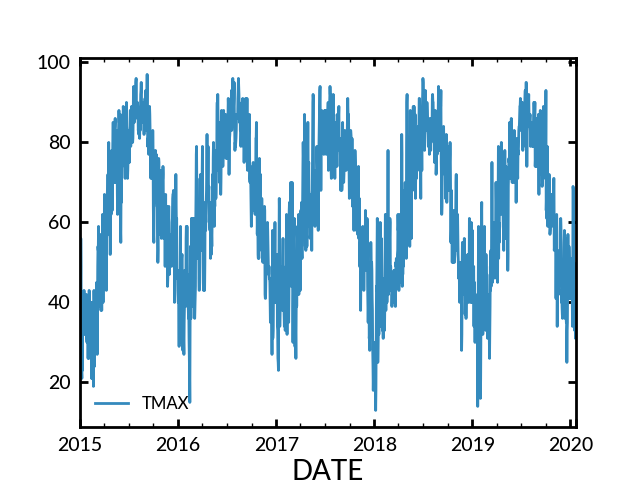

In [44]:
weather.plot('DATE', 'TMAX')

# Merge the weather data with the inspections

In [64]:
df_single_visits = df_single_visits.merge(weather[['DATE', 'TMAX']], left_on='inspection_date', right_on='DATE')
# drop the extra date column
df_single_visits.drop(labels='DATE', axis=1, inplace=True)

# Now we want to see if can calculate a few things about the inspections

* Time since last inspection -- apparently, that is super easy
* Last inspection critical -- y/n
* Last inspection grade (or maybe score)

In [73]:
# Buddy's Burrito and Taco Bar for testing
df_test = df_single_visits[df_single_visits.camis==40393243]

In [74]:
df_test['time_since'] = df_test.groupby('camis')['inspection_date'].diff().apply(lambda x: x.days)

<ipython-input-74-fd37da2ffe37>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['time_since'] = df_test.groupby('camis')['inspection_date'].diff().apply(lambda x: x.days)


In [75]:
df_test

,camis,dba,boro,zipcode,cuisine_description,inspection_date,action,score,grade,latitude,longitude,violation_code,violation_description,critical_flag,inspection_type,TMAX,critical,time_since
26217,40393243,BUDDY'S BURRITO & TACO BAR,Brooklyn,11231.0,Tex-Mex,2017-07-25,Violations were cited in the following area(s).,24.0,NaN,40.685148,-73.994563,"[08A, 02G, 04L, 06E]",[Facility not vermin proof. Harborage or condi...,"[N, Y, Y, Y]","[Cycle Inspection / Initial Inspection, Cycle ...",71,1,NaN
32425,40393243,BUDDY'S BURRITO & TACO BAR,Brooklyn,11231.0,Tex-Mex,2017-10-10,Violations were cited in the following area(s).,16.0,B,40.685148,-73.994563,"[10F, 09B, 04L, 04N, 08C, 08A]",[Non-food contact surface improperly construct...,"[N, N, Y, Y, N, N]","[Cycle Inspection / Re-inspection, Cycle Inspe...",81,1,77.0
39493,40393243,BUDDY'S BURRITO & TACO BAR,Brooklyn,11231.0,Tex-Mex,2017-12-30,Violations were cited in the following area(s).,NaN,NaN,40.685148,-73.994563,[20F],[Current letter grade card not posted.],[N],[Administrative Miscellaneous / Initial Inspec...,23,0,81.0
44828,40393243,BUDDY'S BURRITO & TACO BAR,Brooklyn,11231.0,Tex-Mex,2018-02-13,No violations were recorded at the time of thi...,NaN,NaN,40.685148,-73.994563,[nan],[nan],[nan],[Administrative Miscellaneous / Re-inspection],38,0,45.0
61482,40393243,BUDDY'S BURRITO & TACO BAR,Brooklyn,11231.0,Tex-Mex,2018-06-20,Violations were cited in the following area(s).,13.0,A,40.685148,-73.994563,"[10B, 06D, 06C]",[Plumbing not properly installed or maintained...,"[N, Y, Y]","[Cycle Inspection / Initial Inspection, Cycle ...",83,1,127.0


Now try to say if it had a previous critical

In [115]:
df_test['past_critical'] = df_test.groupby(['camis'])['critical'].shift()

<ipython-input-115-16ee01521f49>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['past_critical'] = df_test.groupby(['camis'])['critical'].shift()


In [116]:
df_test

,camis,dba,boro,zipcode,cuisine_description,inspection_date,action,score,grade,latitude,longitude,violation_code,violation_description,critical_flag,inspection_type,TMAX,critical,time_since,past_critical
26217,40393243,BUDDY'S BURRITO & TACO BAR,Brooklyn,11231.0,Tex-Mex,2017-07-25,Violations were cited in the following area(s).,24.0,NaN,40.685148,-73.994563,"[08A, 02G, 04L, 06E]",[Facility not vermin proof. Harborage or condi...,"[N, Y, Y, Y]","[Cycle Inspection / Initial Inspection, Cycle ...",71,1,NaN,NaN
32425,40393243,BUDDY'S BURRITO & TACO BAR,Brooklyn,11231.0,Tex-Mex,2017-10-10,Violations were cited in the following area(s).,16.0,B,40.685148,-73.994563,"[10F, 09B, 04L, 04N, 08C, 08A]",[Non-food contact surface improperly construct...,"[N, N, Y, Y, N, N]","[Cycle Inspection / Re-inspection, Cycle Inspe...",81,1,77.0,1.0
39493,40393243,BUDDY'S BURRITO & TACO BAR,Brooklyn,11231.0,Tex-Mex,2017-12-30,Violations were cited in the following area(s).,NaN,NaN,40.685148,-73.994563,[20F],[Current letter grade card not posted.],[N],[Administrative Miscellaneous / Initial Inspec...,23,0,81.0,1.0
44828,40393243,BUDDY'S BURRITO & TACO BAR,Brooklyn,11231.0,Tex-Mex,2018-02-13,No violations were recorded at the time of thi...,NaN,NaN,40.685148,-73.994563,[nan],[nan],[nan],[Administrative Miscellaneous / Re-inspection],38,0,45.0,0.0
61482,40393243,BUDDY'S BURRITO & TACO BAR,Brooklyn,11231.0,Tex-Mex,2018-06-20,Violations were cited in the following area(s).,13.0,A,40.685148,-73.994563,"[10B, 06D, 06C]",[Plumbing not properly installed or maintained...,"[N, Y, Y]","[Cycle Inspection / Initial Inspection, Cycle ...",83,1,127.0,0.0


Seems we can do the same thing for previous grade and score

In [117]:
df_test['past_grade'] = df_test.groupby(['camis'])['grade'].shift()
df_test['past_score'] = df_test.groupby(['camis'])['score'].shift()

<ipython-input-117-865418fbfeea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['past_grade'] = df_test.groupby(['camis'])['grade'].shift()
<ipython-input-117-865418fbfeea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['past_score'] = df_test.groupby(['camis'])['score'].shift()


In [118]:
df_test

,camis,dba,boro,zipcode,cuisine_description,inspection_date,action,score,grade,latitude,...,violation_code,violation_description,critical_flag,inspection_type,TMAX,critical,time_since,past_critical,past_grade,past_score
26217,40393243,BUDDY'S BURRITO & TACO BAR,Brooklyn,11231.0,Tex-Mex,2017-07-25,Violations were cited in the following area(s).,24.0,NaN,40.685148,...,"[08A, 02G, 04L, 06E]",[Facility not vermin proof. Harborage or condi...,"[N, Y, Y, Y]","[Cycle Inspection / Initial Inspection, Cycle ...",71,1,NaN,NaN,NaN,NaN
32425,40393243,BUDDY'S BURRITO & TACO BAR,Brooklyn,11231.0,Tex-Mex,2017-10-10,Violations were cited in the following area(s).,16.0,B,40.685148,...,"[10F, 09B, 04L, 04N, 08C, 08A]",[Non-food contact surface improperly construct...,"[N, N, Y, Y, N, N]","[Cycle Inspection / Re-inspection, Cycle Inspe...",81,1,77.0,1.0,NaN,24.0
39493,40393243,BUDDY'S BURRITO & TACO BAR,Brooklyn,11231.0,Tex-Mex,2017-12-30,Violations were cited in the following area(s).,NaN,NaN,40.685148,...,[20F],[Current letter grade card not posted.],[N],[Administrative Miscellaneous / Initial Inspec...,23,0,81.0,1.0,B,16.0
44828,40393243,BUDDY'S BURRITO & TACO BAR,Brooklyn,11231.0,Tex-Mex,2018-02-13,No violations were recorded at the time of thi...,NaN,NaN,40.685148,...,[nan],[nan],[nan],[Administrative Miscellaneous / Re-inspection],38,0,45.0,0.0,NaN,NaN
61482,40393243,BUDDY'S BURRITO & TACO BAR,Brooklyn,11231.0,Tex-Mex,2018-06-20,Violations were cited in the following area(s).,13.0,A,40.685148,...,"[10B, 06D, 06C]",[Plumbing not properly installed or maintained...,"[N, Y, Y]","[Cycle Inspection / Initial Inspection, Cycle ...",83,1,127.0,0.0,NaN,NaN
